## Imports

In [257]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data as data
import os
from torchvision.io import decode_image, ImageReadMode
from torchvision.transforms import v2
import torch


## Data Generation

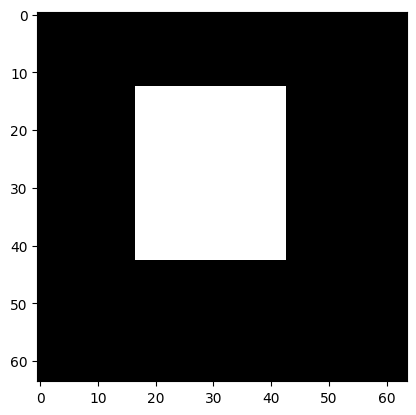

In [236]:
def generate_random_shape(size, shape=None):
    img = np.zeros(shape=(size, size), dtype=np.uint8)
    if not shape:
        shapes = ['rectangle', 'circle', 'line']#'triangle', 'line']
        shape = np.random.choice(shapes)
        thickness = np.random.choice([2,-1])
    thickness = -1

    color = np.random.randint(0,255)
    
    if shape == 'rectangle':
        
        x1, y1 = np.random.randint(10, 20, size=2)
        x2, y2 = np.random.randint(40, 50, size=2)
        
        return cv.rectangle(img, pt1=(x1,y1),pt2=(x2,y2),color=color, thickness=thickness)
    elif shape == 'circle':
        x, y = np.random.randint(size//4,size-size//4,size=2)
        radius = np.random.randint(5,min(size-x,size-y))//2
        return cv.circle(img, center=(x, y), radius=radius, color=color, thickness=thickness)
    elif shape == 'triangle':
        pass
    elif shape == 'line':
        x1, y1 = np.random.randint(size//4, size-size//4, size=2)
        x2, y2 = np.random.randint(size//4, size-size//4, size=2)
        
        return cv.line(img, pt1=(x1, y1), pt2=(x2, y2), color=color, thickness=1)

plt.imshow(generate_random_shape(64,shape='rectangle'), cmap='grey')

In [238]:
for i in range(3000):
    plt.imsave(f'./data/data_rect_3000/img_{i}.png',generate_random_shape(64,shape='rectangle'),cmap='grey')

In [163]:
for i in range(3000):
    plt.imsave(f'./data/data_w_lines_3000/img_{i}.png',generate_random_shape(64),cmap='grey')

for i in range(3000):
    plt.imsave(f'./data/data_3000/img_{i}.png',generate_random_shape(64),cmap='grey')

[ 909 1321  879 1039  909 1432 1728 1984]


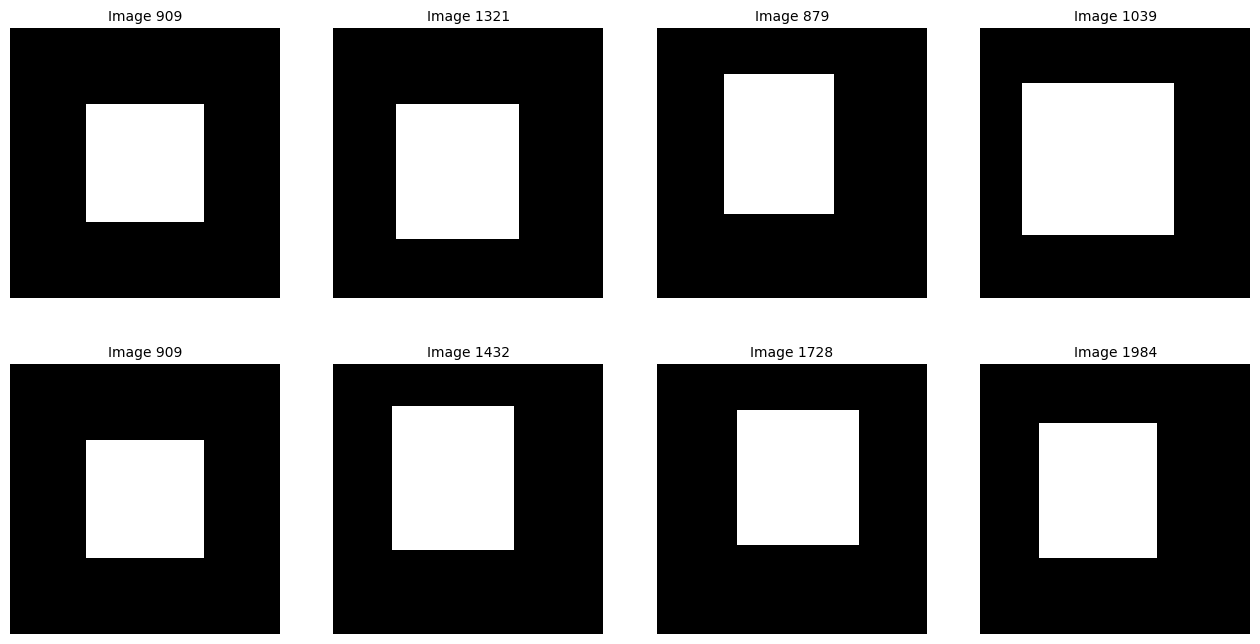

In [239]:
imgs_idx = np.random.choice(range(3000),size=(8))
print(imgs_idx)

figure1 = plt.figure(figsize=(16,8))
i=0
for idx in imgs_idx:

    img = cv.imread(f'./data/data_rect_3000/img_{idx}.png', cv.IMREAD_GRAYSCALE)
    
    ax = figure1.add_subplot(2, 4, i+1)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Image {idx}', fontsize=10)
    i += 1
    


In [259]:
class image_dataset(data.Dataset):
    def __init__(self, path, normalize=True):
        self.normalize = normalize
        self.path = path
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.path,f'img_{idx}.png')
        image = decode_image(img_path,mode=ImageReadMode.GRAY).float()
        if self.normalize:
            normalizer = v2.Normalize(mean=[0], std=[1])
            image = normalizer(image)
        return image
    def __len__(self):
        return len([f for f in os.listdir(self.path) if os.path.isfile(os.path.join(self.path, f))])

img_data = image_dataset('/Users/marcusandersson/Documents/Basic-Diffusion-Model-Demo/data/data_rect_3000')

train_dataloader = data.DataLoader(img_data, batch_size=32, shuffle=True)

## U-Net

In [ ]:


class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvolutionBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvolutionBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvolutionBlock(in_channels, out_channels)

    def forward(self, x, skip_features):
        x = self.upconv(x)
        x = torch.cat((x, skip_features), dim=1)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    def __init__(self, time_dim=1):
        super(UNet, self).__init__()

        self.time_mlp = nn.Sequential(
                    nn.Linear(time_dim, 256),
                    nn.ReLU(),
                    nn.Linear(256, 512)
        )

        self.enc1 = EncoderBlock(1, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        self.bottleneck = ConvolutionBlock(512, 1024)
        

        self.dec4 = DecoderBlock(1024, 512)
        self.dec3 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec1 = DecoderBlock(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t):
        # Encode timestep
        t = t.float().unsqueeze(-1)  # Shape: [batch_size, 1]
        t_emb = self.time_mlp(t)  # Shape: [batch_size, 1024]
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, 1024, 1, 1]


        # Encoder
        enc1, p1 = self.enc1(x)
        enc2, p2 = self.enc2(p1)
        enc3, p3 = self.enc3(p2)
        enc4, p4 = self.enc4(p3)

        # Bottleneck
        bottleneck = self.bottleneck(p4 + t_emb)  # Inject timestep embedding

        # Decoder
        dec4 = self.dec4(bottleneck, enc4)
        dec3 = self.dec3(dec4, enc3)
        dec2 = self.dec2(dec3, enc2)
        dec1 = self.dec1(dec2, enc1)

        # Final layer
        return self.final(dec1)

## Diffusion Process

### Positional encoding

In [183]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, timesteps):
        device = timesteps.device
        half_dim = self.embedding_dim // 2
        div_term = torch.exp(-torch.arange(0, half_dim, device=device) * (np.log(10000.0) / half_dim))
        angles = timesteps[:, None] * div_term
        embeddings = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
        return embeddings

### Forward diffusion

In [264]:
class Diffusion:
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02, variance_schedule='linear'):
        self.timesteps = timesteps
        if variance_schedule == 'linear':
            self.beta = torch.linspace(beta_start, beta_end, timesteps, device='mps')
        elif variance_schedule == 'cosine':
            s = 0.008  # Small constant to prevent division by zero
            x = torch.linspace(0, timesteps, timesteps + 1, device='mps')
            alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            self.alpha_bar = alphas_cumprod[:-1]
            self.beta = 1 - (self.alpha_bar[1:] / self.alpha_bar[:-1])
            self.beta = torch.cat((self.beta, torch.tensor([beta_end], device='mps')))
        else:
            raise ValueError("Unsupported variance schedule. Use 'linear' or 'cosine'.")
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def loss(self, noise, predicted_noise):
        return torch.nn.functional.mse_loss(noise, predicted_noise)

    def forward(self, x0, t):
        # print('x0:',x0.shape)
        noise = torch.randn_like(x0, device='mps')
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        x_t = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
        # print('x_t:',x_t.shape)
        return x_t, noise

    def backward(self, model, x_t, t):
        predicted_noise = model(x_t, t)
        beta_t = self.beta[t][:, None, None, None]
        alpha_t = self.alpha[t][:, None, None, None]
        alpha_bar_t = self.alpha_bar[t][:, None, None, None]
        sqrt_recip_alpha = torch.sqrt(1.0 / alpha_t)
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar_t)
        posterior_mean = sqrt_recip_alpha * (x_t - beta_t * predicted_noise / sqrt_one_minus_alpha_bar)
        return posterior_mean, predicted_noise

torch.Size([1, 64, 64])


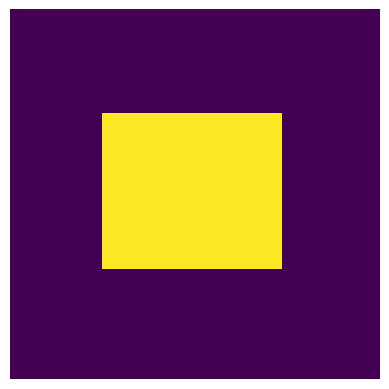

In [ ]:
img = decode_image('/Users/marcusandersson/Documents/Basic-Diffusion-Model-Demo/data/data_rect_3000/img_0.png',mode=ImageReadMode.GRAY)
print(img.shape)

img_np = img.permute(1, 2, 0).numpy()

# Plot
plt.imshow(img_np)
plt.axis("off")
plt.show()

## Training

In [ ]:
device = 'mps'
epochs = 50
timesteps = 100

learning_rate = 0.0001

diffusion = Diffusion(timesteps=timesteps,variance_schedule='cosine')

UNet_model = UNet()
UNet_model.to(device)

optimizer = torch.optim.Adam(UNet_model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    UNet_model.train()
    for step, batch in enumerate(train_dataloader):
        batch = batch.to(device)
        t = torch.randint(0, timesteps, (batch.size(0),), device=device).long()
        x_t, noise = diffusion.forward(batch, t)
        predicted_noise = UNet_model(x_t,t)
        loss = diffusion.loss(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print(f'Epoch {epoch} | Loss: {loss.item()}')

Epoch 0 | Loss: 0.5903657674789429


## Sampling

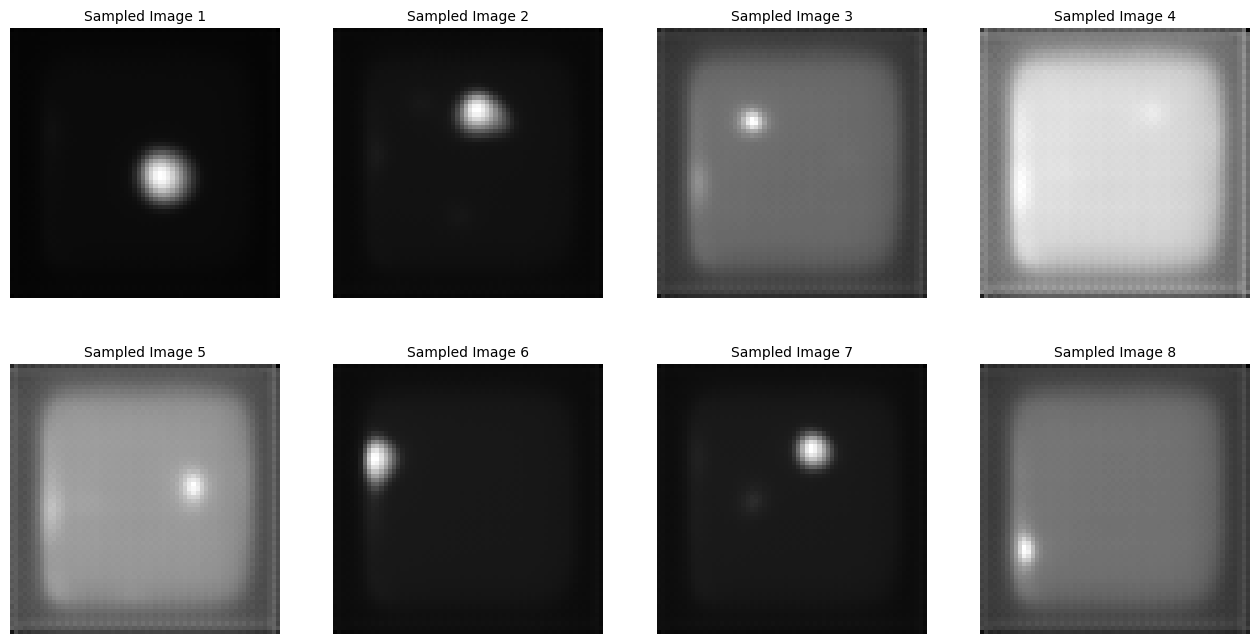

In [272]:
def sample(diffusion, model, shape, timesteps, device='mps'):
    model.eval()
    with torch.no_grad():
        x_t = torch.randn(shape, device=device)  # Start with random noise
        for t in reversed(range(timesteps)):
            t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
            x_t, _ = diffusion.backward(model, x_t, t_tensor)
        return x_t

# Example usage
sampled_images = sample(diffusion, UNet_model, shape=(8, 1, 64, 64), timesteps=timesteps, device=device)

# Visualize the sampled images
figure = plt.figure(figsize=(16, 8))
for i in range(8):
    ax = figure.add_subplot(2, 4, i + 1)
    ax.imshow(sampled_images[i, 0].cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Sampled Image {i+1}', fontsize=10)
plt.show()